In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from collections import OrderedDict
import seaborn as sns

# The Checklist
- [ ] Get the data
- [ ] Do the One Class SVM, Isolation Tree, and Local Outlier Factor
- [ ] Clip the Target
- [ ] Arithmetic Mean


In [2]:
df = pd.read_csv('sample_submission.csv')
df

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.000,9.545,9.265,8.110,8.430,7.150,0.180,...,4.950,1.730,1.800,4.800,3.150,10.665,10.465,16.645,5.750,10.37
1,1,9.10,13.533,40.900,8.770,9.265,6.015,10.070,7.150,1.107,...,20.050,9.530,7.695,4.550,6.950,2.040,5.200,5.725,2.950,2.23
2,2,8.21,3.710,5.420,8.770,9.265,4.550,10.070,7.150,0.020,...,4.580,3.025,3.960,4.935,4.950,4.725,6.075,6.750,3.500,3.17
3,3,8.39,8.700,8.100,9.500,9.200,5.200,8.670,6.670,0.280,...,8.450,2.070,1.730,6.300,4.700,3.500,6.200,8.670,2.900,7.37
4,4,8.07,8.050,8.650,7.960,9.265,3.290,10.070,7.150,0.360,...,2.020,1.730,0.760,4.800,4.970,3.950,2.800,8.400,3.500,3.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,8.08,6.250,8.300,7.795,9.265,5.690,8.555,6.335,0.565,...,14.575,0.636,1.640,4.235,4.100,2.800,3.950,7.695,3.540,2.50
3496,3496,8.09,6.630,6.630,8.370,7.600,0.636,8.430,7.150,1.300,...,4.580,1.730,1.800,4.900,3.150,2.040,6.075,8.415,2.155,2.90
3497,3497,9.95,8.367,8.433,8.770,6.170,5.800,10.400,7.200,0.430,...,20.050,1.440,1.800,4.867,4.833,4.725,4.950,8.400,6.625,4.20
3498,3498,9.52,10.000,6.630,9.545,9.265,3.290,8.980,2.310,0.300,...,20.050,9.530,7.695,10.700,5.400,4.725,3.300,6.750,6.625,5.00


# Setting up the Helper Methods

Now I am going to setup a streamlined k folds and random forest regressor

In [3]:
def test_on_data(x_train, x_test, y_train, y_test):
    rf = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)

    rf.fit(x_train, y_train)
    preds = rf.predict(x_test)
    return mean_squared_error(y_test, preds)

In [4]:
def test_on_data_cv(x, y, cv=5):
    rf = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)

    scores = cross_val_score(rf, x, y, cv=cv, scoring='neg_root_mean_squared_error')
    scores
    return scores

~~TODO: add custom K-Folds~~

In [5]:
def test_with_std(x, y, cv=5, n=10):
    score_total = []
    for i in range(n):
        score_total.append(test_on_data_cv(x, y, cv=cv))
    score_total = np.array(score_total)
    print(f'Mean {score_total.mean()} and std {score_total.std()}')

In [6]:
# Let's try these methods.
# test_with_std(df.drop('target', axis=1), df.target)

For normal k-folds without any change in data, we got a pretty bad score and even worst we got a big std compared to mean. For curisoty sake I'm going to do it on the clipped version too.

In [7]:
# Testing cell, not run by default
# test_with_std(df.drop('target', axis=1), df['target'].clip(7, 16))

Ok this seems better with 0.9 MSE and 0.02 std, MAYBE I SHOULD VALUE STD MORE.

In [8]:
def give_zero_sub(df=df):
    dfc = df.copy()
    dfc.iloc[:]=0
    return dfc

# Half hearted EDA & Outlier Detection

In [9]:
data_to_plot = df.drop(['id'], axis=1)

# Determine the number of columns to plot, 36
num_cols = len(data_to_plot.columns)

# Calculate the number of rows and columns for the subplots
num_rows = (num_cols + 2) // 3
num_cols_per_subplot = min(num_cols, 5)

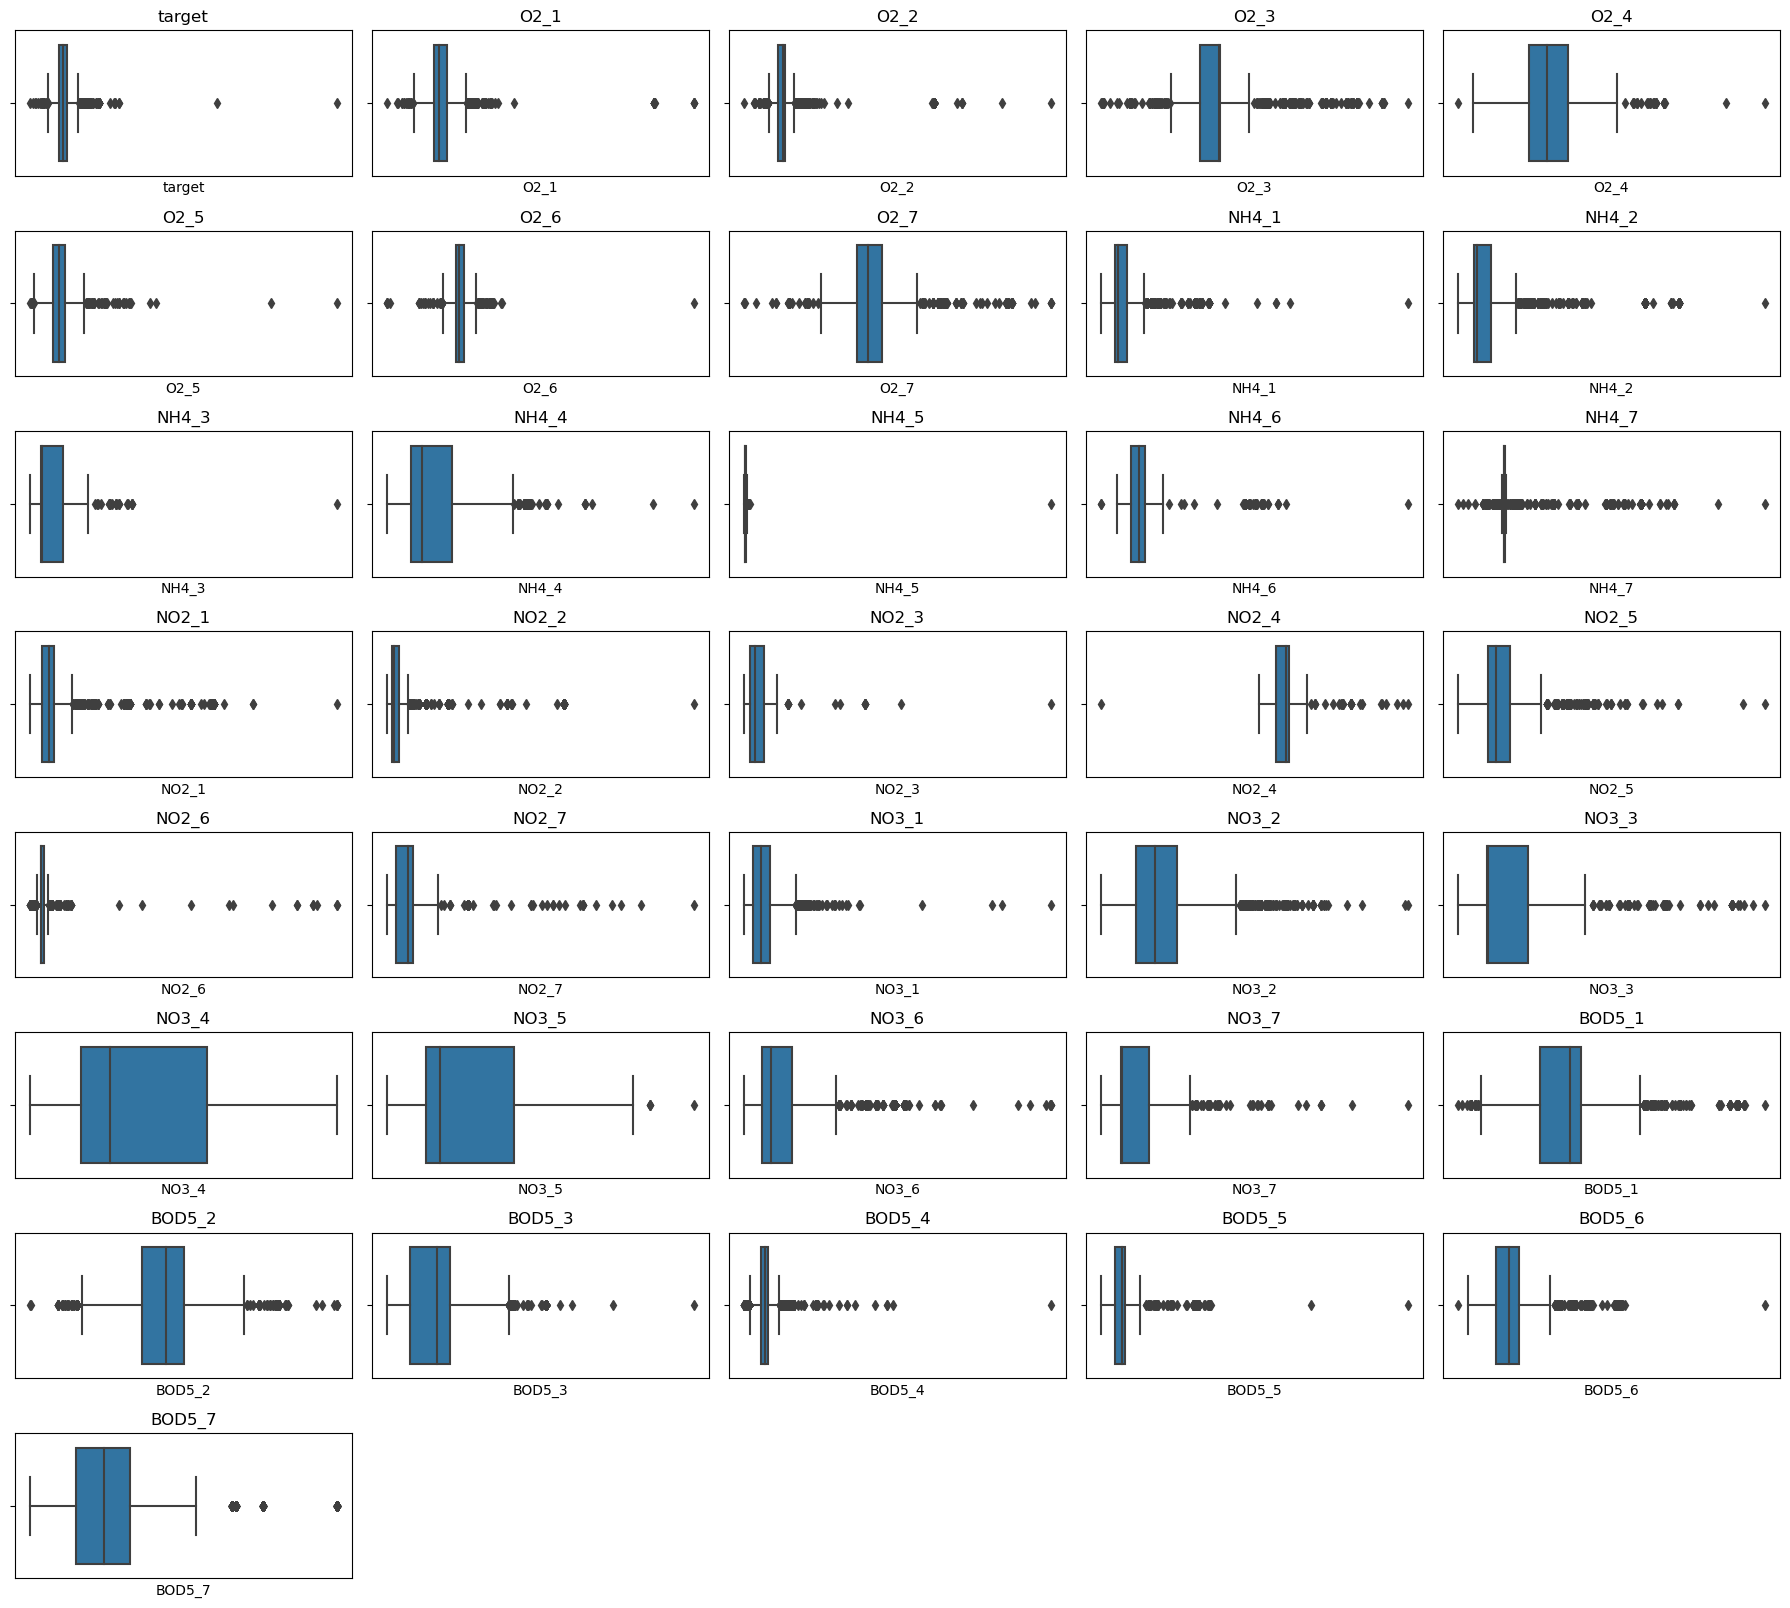

In [10]:
# Create subplots
fig, axes = plt.subplots(num_rows, num_cols_per_subplot, figsize=(18, 2 * num_rows))

# Flatten the axes for iteration
axes = axes.flatten()

# Create box plots for each column
for i, col in enumerate(data_to_plot.columns):
    # The main magic happens here:
    sns.boxplot(x=data_to_plot[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xticks([])  # Remove x-axis labels for better readability
    
# Remove any empty subplots
for i in range(num_cols, num_rows * num_cols_per_subplot):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

<Axes: xlabel='id', ylabel='target'>

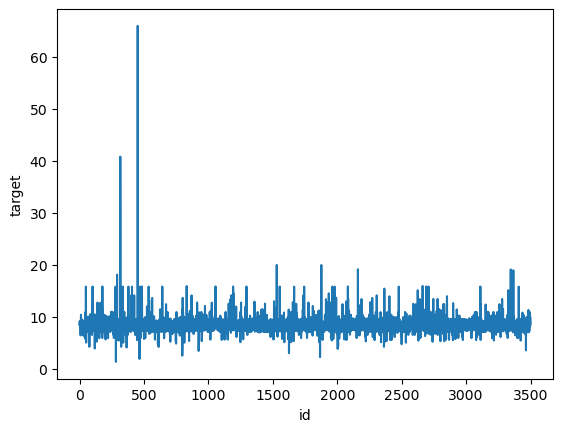

In [11]:
sns.lineplot(data=df, x='id',y='target')

<Axes: xlabel='id', ylabel='O2_1'>

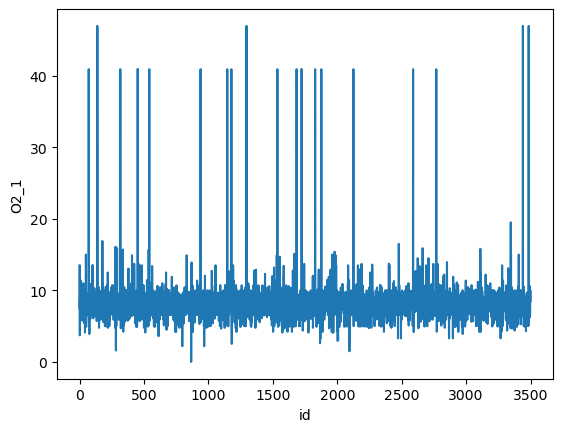

In [12]:
sns.lineplot(data=df, x='id',y='O2_1')

<Axes: xlabel='id', ylabel='O2_2'>

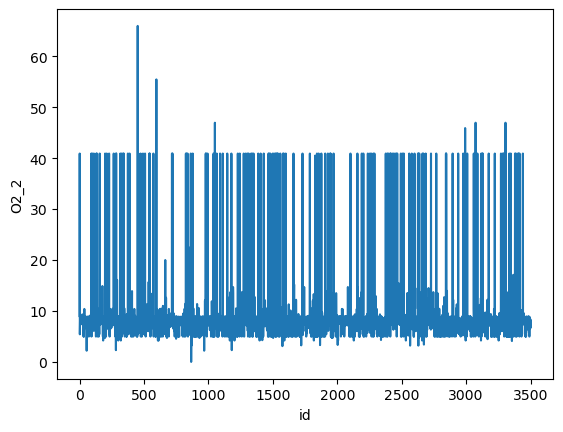

In [13]:
sns.lineplot(data=df, x='id',y='O2_2')

<Axes: xlabel='id', ylabel='BOD5_5'>

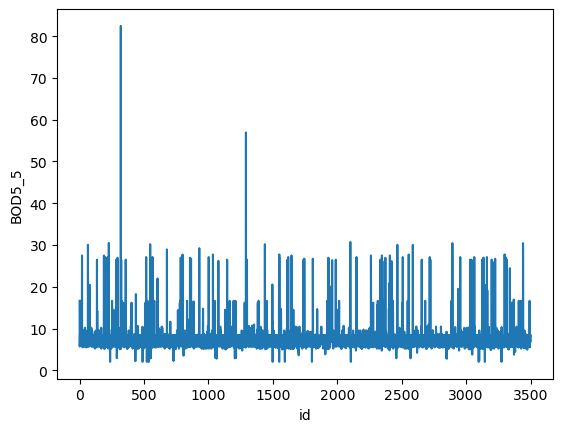

In [14]:
sns.lineplot(data=df, x='id',y='BOD5_5')

In [15]:
df[df.target>20]

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
316,316,40.78,40.90,40.90,9.500,6.805,5.01,8.76,6.805,0.49,...,9.805,4.53,4.42,4.8,3.500,4.650,6.025,5.070,3.850,4.14
451,451,65.93,40.95,65.95,9.265,6.625,5.01,8.37,6.375,0.71,...,7.795,1.73,1.78,4.1,4.645,4.725,5.725,10.645,3.025,3.80


In [16]:
df[df['BOD5_5'] >35]

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
320,320,9.08,4.700,4.200,9.55,6.67,5.22,8.98,6.15,0.450,...,7.180,3.730,3.680,6.950,6.55,4.2,5.725,82.45,3.1,3.17
1291,1291,9.09,4.999,8.433,8.77,7.80,3.29,10.07,7.15,0.473,...,14.775,0.636,7.695,4.913,4.93,3.9,4.950,56.95,3.9,3.85


2 outliers on target which are 316 and 451, from this point we are going to pretend that ID column does not exist, because internet says so.

# Outlier Cleaning

## SVM, Isolation Forest, LOF

In [17]:
def dropped_df(idx):
    return df.drop(idx, axis=0)

In [62]:
def get_svm_idx(nu=.5):
    svm = SGDOneClassSVM(nu)
    svm.fit(df.drop('id', axis=1))
    svm_pred = svm.predict(df.drop('id', axis=1))
    svm_remove_idx = np.where(svm_pred==-1)[0]
    return svm_remove_idx

In [112]:
def get_iso_idx():
    isofor = IsolationForest(random_state=0)
    isofor.fit(df.drop('id',axis=1))
    iso_pred = isofor.predict(df.drop('id',axis=1))
    iso_remove_idx = np.where(iso_pred==-1)[0]
    return iso_remove_idx

In [113]:
def get_lof_idx(cont=0.1):
    lof = LocalOutlierFactor(n_neighbors=3, contamination=cont)
    lof_pred = lof.fit_predict(df.drop('id',axis=1))
    lof_remove_idx = np.where(lof_pred==-1)[0]
    return lof_remove_idx

In [21]:
# # Testing different nu values

# svm_df_3 = dropped_df(get_svm_idx(nu=0.3))
# test_with_std(svm_df_3.drop('target', axis=1), svm_df_3.target, cv=5, n=7)

In [22]:
# svm_df_5 = dropped_df(get_svm_idx(nu=0.5))
# test_with_std(svm_df_5.drop('target', axis=1), svm_df_5.target, cv=5, n=7)

In [23]:
# svm_df_8 = dropped_df(get_svm_idx(nu=0.8))
# test_with_std(svm_df_8.drop('target', axis=1), svm_df_8.target, cv=5, n=7)

In [24]:
# # Testing different contamination values

# iso_df_1 = dropped_df(get_iso_idx(cont='auto'))
# test_with_std(iso_df_1.drop('target', axis=1), iso_df_1.target, cv=5, n=7)

In [25]:
# iso_df_2 = dropped_df(get_iso_idx(cont=0.01))
# test_with_std(iso_df_2.drop('target', axis=1), iso_df_2.target, cv=5, n=7)

In [26]:
# iso_df_3 = dropped_df(get_iso_idx(cont=0.5))
# test_with_std(iso_df_3.drop('target', axis=1), iso_df_3.target, cv=5, n=7)

In [27]:
# # Testing different contamination values

# lof_df_1 = dropped_df(get_lof_idx(cont='auto'))
# test_with_std(lof_df_1.drop('target', axis=1), lof_df_1.target, cv=5, n=7)

In [28]:
# lof_df_2 = dropped_df(get_lof_idx(cont=0.1))
# test_with_std(lof_df_2.drop('target', axis=1), lof_df_2.target, cv=5, n=7)

In [29]:
# iso_df_3 = dropped_df(get_lof_idx(cont=0.5))
# test_with_std(iso_df_3.drop('target', axis=1), iso_df_3.target, cv=5, n=7)

Score i got were:
SVM(nu): 0.3:(-1.39;0.61), 0.5:(-1.39;0.61), 0.8:(-1.39;0.61) - So no meaningful differences.

Isolation Tree(cont): auto:(1.41;0.61), 0.01:(1.40;0.61), **0.5:(0.93; 0.08),**

LocalOutlierFactor(cont): auto:(0.98;0.05), 0.1:(0.92;0.03), **0.5:(0.83; 0.02)**

I wonder if is should this radical numbers for cont, since no one else seems to be using them. 

edit: Ok now i know the reason why people in the Kaggle don't use the big number because it get picky pretty fast. My values are nu=0.3 and both contaminations set to 0.01

In [96]:
svm_remove_idx = get_svm_idx()
iso_remove_idx = get_iso_idx()
lof_remove_idx = get_lof_idx(cont=0.01)

idx_to_remove = np.union1d(np.union1d(lof_remove_idx, iso_remove_idx), svm_remove_idx)

In [101]:
df_clean = dropped_df(idx_to_remove)
len(df_clean)

3345

In [156]:
df.target = df.target.clip(7, 20)

In [157]:
svm = SGDOneClassSVM(nu=0.55)
svm_pred = svm.fit_predict(df.drop('id', axis=1))
svm_keep = svm_pred != -1
df_svm = df.loc[svm_keep, :].reset_index(drop=True)
print(len(df) - len(df_svm))

isofor = IsolationForest(random_state=0)
iso_pred = isofor.fit_predict(df_svm.drop('id', axis=1))
iso_keep = iso_pred != -1
df_iso = df_svm.loc[iso_keep, :].reset_index(drop=True)
print(len(df_svm) - len(df_iso))

lof = LocalOutlierFactor(n_neighbors=3, contamination=0.1)
lof_pred = lof.fit_predict(df_iso.drop(['id', 'target'],axis=1))
keep_cond = lof_pred != -1
df_alt = df_iso.loc[keep_cond, :].reset_index(drop=True)
print(len(df_iso) - len(df_alt))

18
69
342


In [158]:
len(df_alt)

3071

In [159]:
bad_labels = [2365, 1089, 1936, 1680, 211,2294,448, 437,309,1684]
data_final = df_alt[~df_alt['id'].isin(bad_labels)].copy()

In [160]:
X = data_final.drop(['target'], axis=1)
y = data_final.target

rf = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)

rf.fit(X,y)
importances = rf.feature_importances_
s = pd.Series(importances)

selected_features = s.sort_values(ascending=False)[:8]
# The names of first 4 features
X.columns[selected_features.index]

Index(['O2_1', 'O2_2', 'BOD5_5', 'O2_4', 'O2_6', 'NO3_2', 'O2_5', 'BOD5_6'], dtype='object')

In [135]:
alt_important_col_names = ['O2_1', 'O2_2', 'BOD5_5', 'NH4_6']

In [161]:
for column in X.columns:
    if column not in alt_important_col_names:
        data_final[column] = 0

In [164]:
data_final[data_final['target']==7].index.to_numpy()

array([   8,   28,   37,   41,   43,   47,   84,  104,  122,  131,  146,
        152,  170,  174,  180,  229,  231,  234,  248,  281,  282,  288,
        290,  293,  295,  319,  325,  378,  389,  390,  404,  409,  410,
        435,  473,  489,  513,  533,  573,  612,  613,  615,  629,  637,
        652,  654,  671,  686,  697,  698,  711,  743,  804,  825,  885,
        959,  969,  995, 1001, 1062, 1089, 1110, 1140, 1217, 1292, 1301,
       1313, 1339, 1370, 1386, 1411, 1418, 1419, 1428, 1435, 1453, 1489,
       1504, 1545, 1547, 1571, 1585, 1629, 1633, 1648, 1703, 1708, 1709,
       1718, 1719, 1744, 1756, 1757, 1769, 1794, 1829, 1832, 1881, 1890,
       1896, 1937, 1940, 1941, 1951, 1952, 1989, 2003, 2036, 2040, 2048,
       2063, 2070, 2089, 2112, 2115, 2117, 2121, 2133, 2142, 2161, 2164,
       2182, 2186, 2215, 2229, 2260, 2261, 2273, 2344, 2357, 2374, 2385,
       2388, 2395, 2414, 2433, 2452, 2479, 2491, 2510, 2532, 2538, 2555,
       2559, 2561, 2571, 2600, 2606, 2608, 2609, 26

In [169]:
len(data_final[data_final['target']==7])//2

86

In [172]:
num_seven = len(data_final[data_final['target']==7])//2
drop_index = np.random.choice(data_final[data_final['target']==7].index.to_numpy(), num_seven, replace=False)

In [173]:
data_final.drop(drop_index, inplace = True)

In [174]:
data_final

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,16.645,0,0
1,0,9.10,13.533,40.900,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5.725,0,0
2,0,8.21,3.710,5.420,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6.750,0,0
3,0,8.39,8.700,8.100,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8.670,0,0
4,0,8.07,8.050,8.650,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8.400,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066,0,8.65,8.367,8.760,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8.415,0,0
3067,0,8.08,6.250,8.300,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7.695,0,0
3068,0,8.09,6.630,6.630,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8.415,0,0
3069,0,9.95,8.367,8.433,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8.400,0,0


In [175]:
data_final.to_csv('final_noise.csv', index=False)

## Features Importance

In [102]:
X = df.drop(['id','target'], axis=1)
y = df.loc[:,'target']
rf = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)

rf.fit(X,y)
importances = rf.feature_importances_
s = pd.Series(importances)
selected_features = s.sort_values(ascending=False)[:4]
selected_features

0     0.510242
1     0.287625
32    0.075243
15    0.010306
dtype: float64

In [103]:
# The names of first 4 features
X.columns[selected_features.index]

Index(['O2_1', 'O2_2', 'BOD5_5', 'NO2_2'], dtype='object')

Outliers and the hyperparameters of above operations operate imporatance of these features too much but still I am going to choose 4.

In [104]:
columns_idx = selected_features.index.to_list()
columns_idx

[0, 1, 32, 15]

In [105]:
def copy_to_new(df_clean):
    """ This function creates a new copy of cleaned up
    dataframe and just keeps the selected columns."""
    
    df_sub = df_clean.copy()
    df_sub[:]=0
    col_np = np.array(columns_idx)
    # col_np = np.array([0, 1, 12, 32])
    col_np+2
    df_sub.iloc[:, col_np+2] = df_clean.iloc[:,col_np+2]
    return df_sub

# Clipping

In [80]:
def y_clipped(low, high):
    return df_clean.target.clip(low, high)

In [46]:
y_20 = y_clipped(7, 20)
y_16 = y_clipped(7, 16)

In [47]:
# TEST CELL

# test_with_std(X.iloc[:, columns_idx], y_20, n=7)
# test_with_std(X.iloc[:, columns_idx], y_16, n=7)
# test_with_std(X.iloc[:, columns_idx_x], y_20, n=7)
# test_with_std(X.iloc[:, columns_idx_x], y_16, n=7)

In [ ]:
# df_sub.to_csv('subv8_1.csv', index=False)

In [ ]:
# df_sub.target = y_16
# df_sub.to_csv('subv8_2.csv', index=False)

In [ ]:
# test_with_std(X.iloc[:, columns_idx_x], y_clipped(7, 35), n=5)

In [107]:
df_sub = copy_to_new(df_clean)
df_sub.target = y_clipped(7, 20)
# df_sub.to_csv('subv8_3.csv', index=False)

/var/folders/lb/05l0197j4wdgmqspj9s7bgjc0000gn/T/ipykernel_823/1970014178.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_sub[:]=0


# Testing

In [108]:
df_sub

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,16.645,0,0
2,0,8.21,3.710,5.420,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6.750,0,0
3,0,8.39,8.700,8.100,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8.670,0,0
4,0,8.07,8.050,8.650,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8.400,0,0
5,0,8.12,9.000,9.000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8.400,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,0,8.65,8.367,8.760,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8.415,0,0
3495,0,8.08,6.250,8.300,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7.695,0,0
3496,0,8.09,6.630,6.630,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8.415,0,0
3497,0,9.95,8.367,8.433,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8.400,0,0


# Experimental Y Dropping

In [109]:
drop_index = np.random.choice(df_sub[df_sub['target']==7].index.to_numpy(), int(len(df_sub[df_sub['target']==7])/2), replace=False)
df_sub.loc[drop_index]

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
269,0,7.0,7.50,8.50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6.750,0,0
559,0,7.0,6.54,6.54,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8.415,0,0
585,0,7.0,9.70,8.90,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5.725,0,0
266,0,7.0,6.55,8.75,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8.625,0,0
209,0,7.0,7.50,6.40,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5.725,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,0,7.0,7.25,7.40,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7.700,0,0
1866,0,7.0,2.60,3.30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7.695,0,0
2221,0,7.0,5.89,6.49,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9.550,0,0
473,0,7.0,7.10,7.50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5.725,0,0


In [110]:
y_drop_df = df_sub.drop(drop_index)
y_drop_df.shape

(3246, 37)

In [111]:
y_drop_df.to_csv('final_y_drop20.csv', index=False)

# Experimental Artihmatic Mean

In [102]:
def make_mean_df(data1, data2, n):
    res = []
    for i in range(n):
        sub_mean_one = np.array(data1.drop_duplicate().sample(10, replace=False)).mean(axis=0)
        sub_mean_two = np.array(data1.drop_duplicate().sample(10, replace=False)).mean(axis=0)
    
        mean_row = (sub_mean_one + sub_mean_two) / 2
        
        res.append(mean_row)
        
    results_df = pd.DataFrame(results_df, columns=data.columns)
    
    return results_df

# Experimental Get RMSE for Each Sample

In [103]:
def get_custom_rmse(X, y):
    model = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)
    
    y_hat = cross_val_predict(model, X, y, cv=5)  
    rmse_table = []
    rmse_sum = []
    for i in range(len(X)):
        y_true_i = y.iloc[i]
        y_pred_i = y_hat[i]
        rmse_i = np.sqrt(mean_squared_error([y_true_i], [y_pred_i]))
        rmse_table.append((i, rmse_i))
        rmse_sum.append(rmse_i)
    
    print(np.mean(rmse_sum))
    sorted_rmse = OrderedDict(sorted(rmse_table, key=lambda x: x[1], reverse=True))
    return sorted_rmse

In [109]:
X=df_sub.drop(columns=['target'])
y=df_sub['target']
sorted_rmse_contributions = get_custom_rmse(X, y)

0.6916506009203781


In [110]:
worst_indexes = list(sorted_rmse_contributions.keys())[:50]

print("Top 50 Indexes with High RMSE:")
for index in worst_indexes:
    rmse = sorted_rmse_contributions[index]
    print(f"At {index}, RMSE is {rmse}")

Top 50 Indexes with High RMSE:
At 311, RMSE is 25.534280639684678
At 3317, RMSE is 11.178547805621129
At 1845, RMSE is 10.63650887662334
At 3277, RMSE is 9.376152771173423
At 2327, RMSE is 7.519926145501491
At 1269, RMSE is 7.274653583333366
At 3297, RMSE is 6.806793869559897
At 1, RMSE is 6.689762755067816
At 2803, RMSE is 6.603416076538025
At 2362, RMSE is 6.468419174748462
At 629, RMSE is 6.130368273101725
At 1500, RMSE is 5.541142304768222
At 1953, RMSE is 5.4540924563881035
At 1707, RMSE is 5.3951554783142015
At 1554, RMSE is 5.3642715437645325
At 1746, RMSE is 5.331231359903285
At 784, RMSE is 5.321008716863002
At 2046, RMSE is 5.092798121471398
At 456, RMSE is 4.902426584682718
At 2268, RMSE is 4.902319825001133
At 396, RMSE is 4.801879796535733
At 373, RMSE is 4.79082144749461
At 1168, RMSE is 4.491486258192227
At 2123, RMSE is 4.341800896335036
At 1650, RMSE is 3.858422647184568
At 1880, RMSE is 3.830212971907324
At 2032, RMSE is 3.6430534103516106
At 518, RMSE is 3.5893266692

In [111]:
best_indexes = list(sorted_rmse_contributions.keys())[-50:][::-1]

print("Top 50 Indexes with Low RMSE:")
for index in best_indexes:
    rmse = sorted_rmse_contributions[index]
    print(f"At {index}, RMSE is {rmse}")

Top 50 Indexes with Low RMSE:
At 1481, RMSE is 7.270041612894573e-05
At 799, RMSE is 0.00048541103297949917
At 2981, RMSE is 0.0006901788447315482
At 3119, RMSE is 0.0008591446987331608
At 2858, RMSE is 0.0012752119061545386
At 2156, RMSE is 0.0014244231846429756
At 1573, RMSE is 0.0015310551787983684
At 326, RMSE is 0.0018075991606600894
At 2844, RMSE is 0.0020534489718144755
At 1504, RMSE is 0.0023501715276790236
At 995, RMSE is 0.002442194737874104
At 165, RMSE is 0.002759176900772431
At 853, RMSE is 0.0028078125958295175
At 3181, RMSE is 0.0030938967542351037
At 1153, RMSE is 0.0031985725881362725
At 2622, RMSE is 0.003746103526472311
At 1487, RMSE is 0.004138354196641103
At 902, RMSE is 0.004421999977619606
At 1796, RMSE is 0.004502921305226337
At 1843, RMSE is 0.004974250397201452
At 2020, RMSE is 0.005003756676307702
At 812, RMSE is 0.005049651576804592
At 3206, RMSE is 0.005407054971176883
At 2334, RMSE is 0.005410048550045232
At 1303, RMSE is 0.005722844566060203
At 221, RMSE 

In [112]:
final_data=df_sub.drop(best_indexes, axis=0)

KeyError: '[2793] not found in axis'

In [108]:
final_data.shape

(3448, 37)

In [ ]:
worst_indexes

In [98]:
final_data= pd.concat([final_data, df_clean.iloc[worst_indexes]], axis="rows")

In [99]:
final_data.to_csv("final_sub-1.csv",index=False)
print(final_data.shape)
final_data.head()

(3448, 37)


,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.645,0.0,0.0
1,0,9.10,13.533,40.90,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.725,0.0,0.0
2,0,8.21,3.710,5.42,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.750,0.0,0.0
3,0,8.39,8.700,8.10,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.670,0.0,0.0
4,0,8.07,8.050,8.65,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.400,0.0,0.0


40.78